# VarClump2D: Concept test

## _Without optimizations..._

In [1]:
%matplotlib inline

import sys
import numba
#import matlab.engine
import numpy as np
import scipy as sp
import sympy as sym
import numexpr as ne
from math import sqrt, log, floor, ceil
import matplotlib.pyplot as plt
from scipy import interpolate, optimize
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn.cluster import KMeans

#import of acalib helper functions
sys.path.append('../../ACALIB/')
from acalib import acontainer as ac

## Helpers visualization functions

In [2]:
"""
Helper function to visualize the quality of the solution
"""
def plotter(c, sig, xc, resolution=10, title=None):
    _xe = np.linspace(0., 1., 10*N, endpoint=True)
    _Dx = np.empty((10*N,N))
    for k in range(10*N):
        _Dx[k,:] = (_xe[k] - xc)

    phi_m = phi(_Dx, sig)
    u = np.dot(phi_m, c)
    plt.figure(figsize=(10,6))
    plt.plot(_xe, u, 'r-', label='Solution')
    plt.plot(x_, f(x_), 'b--', label='Data')
    plt.plot(xe, f(xe), 'go', label='Evaluation points')
    plt.title(title)
    plt.legend(bbox_to_anchor=(1.3, 1.0))
    plt.show()

def plot_sol(c, sig, xc, yc, cut_value=0, resolution=4, title=None):
    _xe = np.linspace(0., 1., 41*resolution)[1:-1]
    _ye = np.linspace(0., 1., 41*resolution)[1:-1]
    len_xe = len(_xe); len_ye = len(_ye)
    Xe,Ye = np.meshgrid(_xe, _ye, sparse=False)
    xe = Xe.ravel(); ye = Ye.ravel()
    Nc = len(xc)
    Ne = len(xe)
    
    """ 
    Computing distance matrices
    """
    #distance matrices
    Dx = np.empty((Ne,Nc))
    Dy = np.empty((Ne,Nc))
    for k in range(Ne):
        Dx[k,:] = xe[k]-xc
        Dy[k,:] = ye[k]-yc
    """
    Computing the Phi matrix
    """
    phi_m = phi(Dx, Dy, sig.reshape(1,-1))
    u = np.dot(phi_m, c**2) + cut_value
    u = u.reshape(len_xe, len_ye)
    
    """
    2D plot
    """
    plt.figure(figsize=(9,9))
    plt.imshow(np.log10(np.abs(u)+1e-10))
    plt.title('Solution')
    plt.axis('off')
    plt.colorbar()
    plt.show()
"""    
    X,Y = np.meshgrid(_xe, _ye,sparse=True)
    fig = plt.figure(figsize=(15,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, u, linewidth=0.1, cmap='jet')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('I')
    plt.title('Solution')
    plt.show()"""

"    \n    X,Y = np.meshgrid(_xe, _ye,sparse=True)\n    fig = plt.figure(figsize=(15,8))\n    ax = fig.add_subplot(111, projection='3d')\n    ax.plot_surface(X, Y, u, linewidth=0.1, cmap='jet')\n    ax.set_xlabel('x')\n    ax.set_ylabel('y')\n    ax.set_zlabel('I')\n    plt.title('Solution')\n    plt.show()"

## Helpers computing functions

In [3]:
"""
Computes RMS value of N-dimensional numpy array
"""
def estimate_rms(data):
    ret = np.sum(data*data) / np.size(data)
    return np.sqrt(ret)

## Loading data 2D: Stacking on frequency

In [4]:
"""
Loading data
"""
cont = ac.AContainer()
#cont.load('../../bindata/fits/cubes/Antennae_North.CO3_2Line.Clean.pcal1.image.fits')
#cont.load('../../bindata/fits/cubes/Antennae_South.CO3_2Line.Clean.pcal1.image.fits')
#cont.load('../../bindata/fits/cubes/CenA.CO2_1Line.Clean.image.fits')
#cont.load('../../bindata/fits/cubes/M100line.image.fits')
cont.load('../../ACALIB/bindata/fits/cubes/Orion.methanol.cbc.contsub.image.fits')
#cont.load('../../bindata/fits/cubes/ALMA01000740.fits')

cube = cont.primary
spar = cube.standarize()
data = cube.stack(axis=(0))
data /= data.max()

INFO: Processing HDU 0 (Image) [acalib.io.formats]
INFO: 4D data detected: assuming RA-DEC-FREQ-STOKES (like CASA-generated ones), and dropping STOKES [acalib.io.formats]


In [5]:
"""
Generating the data function
"""
x = np.linspace(0., 1., len(data[0]), endpoint=True)
y = np.linspace(0., 1., len(data[1]), endpoint=True)
f = sp.interpolate.interp2d(x, y, data, kind='linear')

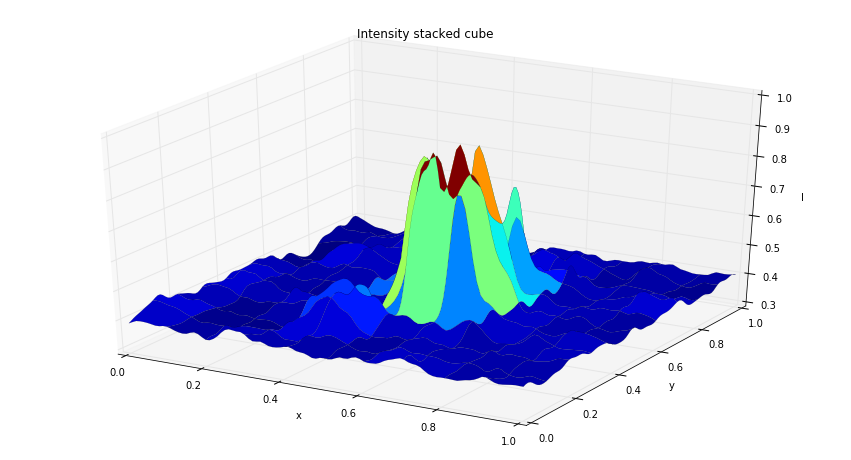

In [6]:
X,Y = np.meshgrid(x,y,sparse=True)
#3d plot
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, data, linewidth=0.1, cmap='jet')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('I')
plt.title('Intensity stacked cube')
plt.show()

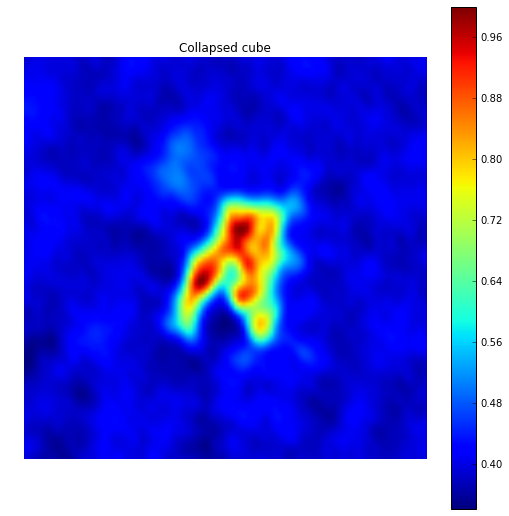

In [7]:
plt.figure(figsize=(9,9))
plt.imshow(data)
plt.title('Collapsed cube')
plt.axis('off')
plt.colorbar()
plt.show()

## Euler-Lagrange Derivation

Given the following functional: 

$$J(u) = \int_{\Omega \subset \mathbb{R}} L(x, y, u, u_x, u_y) \ d\Omega  = \int_{\Omega \subset \mathbb{R}}(u(x,y)-f_0(x,y))^2 + \alpha \ \Psi_1(u(x,y)-f_0(x,y)) + \beta \ \Psi_2(\left|\nabla u(x,y)\right|^2) \ d\Omega $$

then when we try to minimize it, the corresponding Euler-Lagrange equation becomes:

$$
\frac{\partial L}{\partial u}-\frac{d}{dx}\frac{\partial L}{\partial u_x} - \frac{d}{dy}\frac{\partial L}{\partial u_y}= 0$$

$$
2(u-f) + \alpha \Psi_1'(u-f) -2\beta \Big( 2\Psi_2''(u_x^2+u_y^2) \left[(u_x u_{xx} + u_y u_{yx})u_x + (u_x u_{xy} + u_y u_{yy})u_y \right] + \Psi_2'(u_x^2 + u_y^2) \left[u_{xx}+u_{yy} \right] \Big) = 0
$$

whit boundary condition $u(\partial \Omega) = f(\partial \Omega)$. The proposed solution has the form of a linear combination of Gaussian functions:

$$u(x,y) = \sum_{i=1}^N c_i \ \phi(x, y;\ x_i, \sigma_i) = \sum_{i=1}^N c_i \ e^{-\frac{(x-x_i)^2 + (y-y_i)^2}{2 \sigma_i^2}}$$

## Defining and computing the penalizing functions $\Psi_1$ and $\Psi_2$ (will be the same)

In [8]:
"""
General Psi penalizing function (applicable in both cases)
"""
def psi(x, lamb=1.):
    x = lamb*x
    ret = np.empty(x.shape)
    mask0 = x<=0.
    mask1 = x>=1.
    mask01 = np.logical_and(np.logical_not(mask0),np.logical_not(mask1))
    ret[mask0] = 0.
    ret[mask1] = 1.
    #evaluation on 0-1
    x = x[mask01]
    ret[mask01] = ne.evaluate('10*x**3 - 15*x**4 + 6*x**5')
    return ret

def d1psi(x, lamb=1.):
    x = lamb*x
    ret = np.empty(x.shape)
    mask0 = x<=0.
    mask1 = x>=1.
    mask01 = np.logical_and(np.logical_not(mask0),np.logical_not(mask1))
    ret[mask0] = 0.
    ret[mask1] = 0.
    #evaluation on 0-1
    x = x[mask01]
    ret[mask01] = ne.evaluate('30*x**2 - 60*x**3 + 30*x**4')
    return lamb*ret

def d2psi(x, lamb=1.):
    x = lamb*x
    ret = np.empty(x.shape)
    mask0 = x<=0.
    mask1 = x>=1.
    mask01 = np.logical_and(np.logical_not(mask0),np.logical_not(mask1))
    ret[mask0] = 0.
    ret[mask1] = 0.
    #evaluation on 0-1
    x = x[mask01]
    ret[mask01] = ne.evaluate('60*x - 180*x**2 + 120*x**3')
    return (lamb**2)*ret

## $\phi$-RBF function to use and its derivatives

In [9]:
#minimal broadening of gaussians
minsig = 0.001

"""
RBF (Gaussian) functions and its derivatives
"""
def phi(x, y, sig):
    retval = ne.evaluate('exp(-(x**2+y**2)/(2*sig**2))')
    return retval

def phix(x, y, sig):
    retval = ne.evaluate('(-1./sig**2) * exp(-(x**2+y**2)/(2*sig**2)) * x')
    return retval

def phiy(x, y, sig):
    retval = ne.evaluate('(-1./sig**2) * exp(-(x**2+y**2)/(2*sig**2)) * y')
    return retval

#same as phiyx
def phixy(x, y, sig):
    retval = ne.evaluate('(1./sig**4) * exp(-(x**2+y**2)/(2*sig**2)) * (x*y)')
    return retval

def phixx(x, y, sig):
    retval = ne.evaluate('(1./sig**4) * exp(-(x**2+y**2)/(2*sig**2)) * (x**2 - sig**2)')
    return retval

def phiyy(x, y, sig):
    retval = ne.evaluate('(1./sig**4) * exp(-(x**2+y**2)/(2*sig**2)) * (y**2 - sig**2)')
    return retval

## Euler-Lagrange function class definition

In [10]:
class ELFunc():
    def __init__(self, f, xe, ye, xc, yc, xb, yb, c0, sig0, d1psi1=None, 
                 d1psi2=None, d2psi2=None, a=0., b=0., lamb1=1., lamb2=1., cut_value=0):
        #data function at evaluation and boundary points
        f0 = np.array([f(xe[i],ye[i]) for i in range(len(xe))]).ravel()
        fb = np.array([f(xb[i],yb[i]) for i in range(len(xb))]).ravel()
        len_f0 = len(f0)
        len_c0 = len(c0)
        len_sig0 = len(sig0)
        Ne = len(xe)
        Nc = len(xc)
        Nb = len(xb)

        """ 
        Computing distance matrices
        """
        #distance matrices
        Dx = np.empty((Ne,Nc))
        Dy = np.empty((Ne,Nc))
        for k in range(Ne):
            Dx[k,:] = xe[k]-xc
            Dy[k,:] = ye[k]-yc
        #distance matrices for boundary points
        Dxb = np.empty((Nb,Nc))
        Dyb = np.empty((Nb,Nc))
        for k in range(Nb):
            Dxb[k,:] = xb[k]-xc
            Dyb[k,:] = yb[k]-yc
            
        """
        Computing Phi matrices
        """
        phi_m = phi(Dx, Dy, sig0.reshape(1,-1))
        phix_m = phix(Dx, Dy, sig0.reshape(1,-1))
        phiy_m = phiy(Dx, Dy, sig0.reshape(1,-1))
        phixx_m = phixx(Dx, Dy, sig0.reshape(1,-1))
        phixy_m = phixy(Dx, Dy, sig0.reshape(1,-1))
        phiyy_m = phiyy(Dx, Dy, sig0.reshape(1,-1))
        
        """
        Storing important atributes
        """
        self.f0 = f0
        self.fb = fb
        self.xe = xe; self.ye = ye
        self.xc = xc; self.yc = yc
        self.xb = xb; self.yb = yb
        self.Dx = Dx; self.Dxb = Dxb
        self.Dy = Dy; self.Dyb = Dyb
        self.phi_m = phi_m
        self.phix_m = phix_m
        self.phiy_m = phiy_m
        self.phixx_m = phixx_m
        self.phiyy_m = phiyy_m
        self.phixy_m = phixy_m
        self.c = c0
        self.sig = sig0
        self.d1psi1 = d1psi1
        self.d1psi2 = d1psi2
        self.d2psi2 = d2psi2
        self.a = a
        self.b = b
        self.lamb1 = lamb1
        self.lamb2 = lamb2
        self.cut_value = cut_value
        
    def set_c(self, c):
        self.c = c

    
    def set_sig(self, sig):
        self.sig = sig
        """
        Re-computing Phi matrices
        """
        self.phi_m = phi(self.Dx, self.Dy, sig.reshape(1,-1))
        #self.phix_m = phix(self.Dx, self.Dy, sig.reshape(1,-1))
        #self.phiy_m = phiy(self.Dx, self.Dy, sig.reshape(1,-1))
        #self.phixx_m = phixx(self.Dx, self.Dy, sig.reshape(1,-1))
        #self.phixy_m = phixy(self.Dx, self.Dy, sig.reshape(1,-1))
        #self.phiyy_m = phiyy(self.Dx, self.Dy, sig.reshape(1,-1))
    
    def F(self, X):
        N = len(X)/2
        c_squared = X[0:N]**2
        sig = X[N:]
        
        """
        Computing the Phi-matrices
        """
        phi_m = phi(self.Dx, self.Dy, sig.reshape(1,-1))
        #phix_m = phix(self.Dx, self.Dy, sig.reshape(1,-1))
        #phiy_m = phiy(self.Dx, self.Dy, sig.reshape(1,-1))
        #phixx_m = phixx(self.Dx, self.Dy, sig.reshape(1,-1))
        #phixy_m = phixy(self.Dx, self.Dy, sig.reshape(1,-1))
        #phiyy_m = phiyy(self.Dx, self.Dy, sig.reshape(1,-1))
        
        """
        Computing u, ux, uy, ...
        """
        u = np.dot(phi_m, c_squared) + self.cut_value
        #ux = np.dot(phix_m, c_squared)
        #uy = np.dot(phiy_m, c_squared)
        #uxx = np.dot(phixx_m, c_squared)
        #uyy = np.dot(phiyy_m, c_squared)
        #uxy = np.dot(phixy_m, c_squared)
        
        """
        Computing the EL equation
        """
        """el = 2.*(u-self.f0) + \
            self.a*self.d1psi1(u-self.f0, self.lamb1) - \
            2*self.b*(2*self.d2psi2(ux**2 + uy**2, self.lamb2) * ((ux*uxx + uy*uxy)*ux + (ux*uxy + uy+uyy)*uy) + \
                      self.d1psi2(ux**2 + uy**2, self.lamb2)*(uxx + uyy))"""
        #el = 2.*(u-self.f0) + self.a*self.d1psi1(u-self.f0, self.lamb1)
        el = 2.*(u-self.f0)
        
        """
        Boundary conditions
        """
        bc = np.dot(phi(self.Dxb, self.Dyb, sig.reshape(1,-1)), c_squared) - self.fb
        return np.concatenate([el,bc])
    
    def F1(self, c):
        c_squared = c**2
        
        """
        Computing u, ux, uy, ...
        """
        u = np.dot(self.phi_m, c_squared) + self.cut_value
        #ux = np.dot(phix_m, c_squared)
        #uy = np.dot(phiy_m, c_squared)
        #uxx = np.dot(phixx_m, c_squared)
        #uyy = np.dot(phiyy_m, c_squared)
        #uxy = np.dot(phixy_m, c_squared)
        
        """
        Computing the EL equation
        """
        """el = 2.*(u-self.f0) + \
            self.a*self.d1psi1(u-self.f0, self.lamb1) - \
            2*self.b*(2*self.d2psi2(ux**2 + uy**2, self.lamb2) * ((ux*uxx + uy*uxy)*ux + (ux*uxy + uy+uyy)*uy) + \
                      self.d1psi2(ux**2 + uy**2, self.lamb2)*(uxx + uyy))"""
        #el = 2.*(u-self.f0) + self.a*self.d1psi1(u-self.f0, self.lamb1)
        el = 2.*(u-self.f0)
        
        """
        Boundary conditions
        """
        bc = np.dot(phi(self.Dxb, self.Dyb, self.sig.reshape(1,-1)), c_squared) - self.fb
        return np.concatenate([el,bc])
        
    def F2(self, sig):

        """
        Computing the Phi-matrices
        """
        phi_m = phi(self.Dx, self.Dy, sig.reshape(1,-1))
        #phix_m = phix(self.Dx, self.Dy, sig.reshape(1,-1))
        #phiy_m = phiy(self.Dx, self.Dy, sig.reshape(1,-1))
        #phixx_m = phixx(self.Dx, self.Dy, sig.reshape(1,-1))
        #phixy_m = phixy(self.Dx, self.Dy, sig.reshape(1,-1))
        #phiyy_m = phiyy(self.Dx, self.Dy, sig.reshape(1,-1))
        
        """
        Computing u, ux, uy, ...
        """
        u = np.dot(phi_m, self.c**2) + self.cut_value
        #ux = np.dot(phix_m, c_squared)
        #uy = np.dot(phiy_m, c_squared)
        #uxx = np.dot(phixx_m, c_squared)
        #uyy = np.dot(phiyy_m, c_squared)
        #uxy = np.dot(phixy_m, c_squared)
        
        """
        Computing the EL equation
        """
        """el = 2.*(u-self.f0) + \
            self.a*self.d1psi1(u-self.f0, self.lamb1) - \
            2*self.b*(2*self.d2psi2(ux**2 + uy**2, self.lamb2) * ((ux*uxx + uy*uxy)*ux + (ux*uxy + uy+uyy)*uy) + \
                      self.d1psi2(ux**2 + uy**2, self.lamb2)*(uxx + uyy))"""
        #el = 2.*(u-self.f0) + self.a*self.d1psi1(u-self.f0, self.lamb1)
        el = 2.*(u-self.f0)
        
        """
        Boundary conditions
        """
        bc = np.dot(phi(self.Dxb, self.Dyb, sig.reshape(1,-1)), self.c**2) - self.fb
        return np.concatenate([el,bc])

$$
2(u-f) + \alpha \Psi_1'(u-f) -2\beta \Big( 2\Psi_2''(u_x^2+u_y^2) \left[(u_x u_{xx} + u_y u_{yx})u_x + (u_x u_{xy} + u_y u_{yy})u_y \right] + \Psi_2'(u_x^2 + u_y^2) \left[u_{xx}+u_{yy} \right] \Big) = 0
$$

## Centers and evaluation points

#### Thresholded data: Over the RMS value.

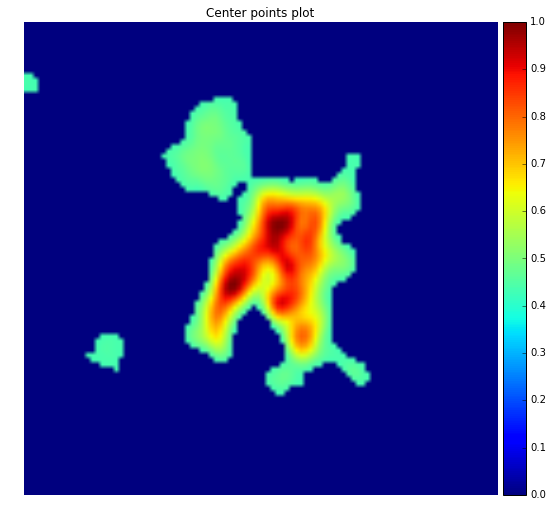

In [11]:
plt.figure(figsize=(9,9))
ax = plt.gca()
_data = np.zeros(data.shape)
mask = data > estimate_rms(data)
_data[mask] = data[mask]
im = ax.imshow(_data)
plt.title('Center points plot')
plt.axis('off')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.08)
plt.colorbar(im, cax=cax)
plt.show()

In [12]:
"""
Boundary points
"""
#number of boundary points by side
Nb = 5
Nc = 200
Ne = 2*Nc-4*Nb

xb = []
yb = []

for val in np.linspace(0., 1., Nb+1)[0:-1]:
    xb.append(val)
    yb.append(0.)
for val in np.linspace(0., 1., Nb+1)[0:-1]:
    xb.append(1.)
    yb.append(val)
for val in np.linspace(0., 1., Nb+1)[::-1][:-1]:
    xb.append(val)
    yb.append(1.)
for val in np.linspace(0., 1., Nb+1)[::-1][:-1]:
    xb.append(0.)
    yb.append(val)
xb = np.asarray(xb)
yb = np.asarray(yb)

In [39]:
def accumulation_points_finder(x, y, data, n_points=100, method='weighted_kmeans', factor=1., cut_value=0.):
    #computing the rms
    rms = estimate_rms(data)
    #structuring the data
    X,Y = np.meshgrid(x, y, sparse=False)
    if cut_value > 0.:
        mask = data > cut_value
        #applying the mask
        X = X[mask]; Y = Y[mask]; data = data[mask]
        _data = np.array([X, Y, data])
    else:
        X = X.ravel(); Y = Y.ravel(); data = data.ravel()
        _data = np.array([X, Y, data])

    if method=='kmeans':
        #kmeans object instantiation
        kmeans = KMeans(init='k-means++', n_clusters=n_points, n_init=25, n_jobs=2)
        #performing kmeans clustering
        kmeans.fit(_data.T)
        #returning just (x,y) positions
        return kmeans.cluster_centers_[:,:2]
    elif method=='weighted_kmeans':
        res = []
        weights =[]
        for i in range(len(data)):
            w = int(ceil((data[i]/rms)**factor))
            weights.append(w)
            res.extend([[X[i],Y[i]]]*w)
        res = np.asarray(res)
        #kmeans object instantiation
        kmeans = KMeans(init='k-means++', n_clusters=n_points, n_init=25, n_jobs=2)
        #performing kmeans clustering
        kmeans.fit(res)
        #returning just (x,y) positions
        return kmeans.cluster_centers_[:,:2]

def points_plot(data, center_points=None, collocation_points=None, boundary_points=None):
    if (center_points is not None) and (collocation_points is None):
        plt.figure(figsize=(12,12))
        plt.imshow(data)
        plt.scatter(center_points[:,0]*100, center_points[:,1]*100, c='r', s=5, label='center')
        plt.title('Center points')
        plt.axis('off')
    elif (center_points is None) and (collocation_points is not None):
        plt.figure(figsize=(12,12))
        plt.imshow(data)
        plt.scatter(collocation_points[:,0]*100, collocation_points[:,1]*100, c='g', s=5, label='collocation')
        plt.title('Collocation points')
        plt.axis('off')
    elif (center_points is not None) and (collocation_points is not None):
        fig = plt.figure(figsize=(20,15))
        ax1 = fig.add_subplot(121)
        ax1.imshow(data)
        ax1.scatter(center_points[:,0]*100, center_points[:,1]*100, c='r', s=5, label='center')
        ax1.set_title('Center points')
        ax1.axis('off')
        ax2 = fig.add_subplot(122)
        ax2.imshow(data)
        ax2.scatter(collocation_points[:,0]*100, collocation_points[:,1]*100, c='g', s=5, label='collocation')
        ax2.set_title('Collocation points')
        ax2.axis('off')
    #if boundary_points is not None and len(boundary_points[0])!=0:
    #    plt.scatter(boundary_points[0]*100, boundary_points[1]*100, c='y', s=40, label="boundary")
    #plt.colorbar(im, cax=cax)
    #fig.legend(bbox_to_anchor=(1.2, 1.0))
    plt.show()

### Without threshold

In [33]:
center_points = accumulation_points_finder(x, y, data, n_points=Nc, cut_value=0., method='weighted_kmeans')
collocation_points = accumulation_points_finder(x, y, data, n_points=Ne, cut_value=0., method='weighted_kmeans')

In [ ]:
points_plot(data, center_points, collocation_points)

### With threshold

In [41]:
center_points = accumulation_points_finder(x, y, data, n_points=Nc, cut_value=estimate_rms(data), factor=5., method='weighted_kmeans')
collocation_points = accumulation_points_finder(x, y, data, n_points=Ne, cut_value=estimate_rms(data), factor=5., method='weighted_kmeans')

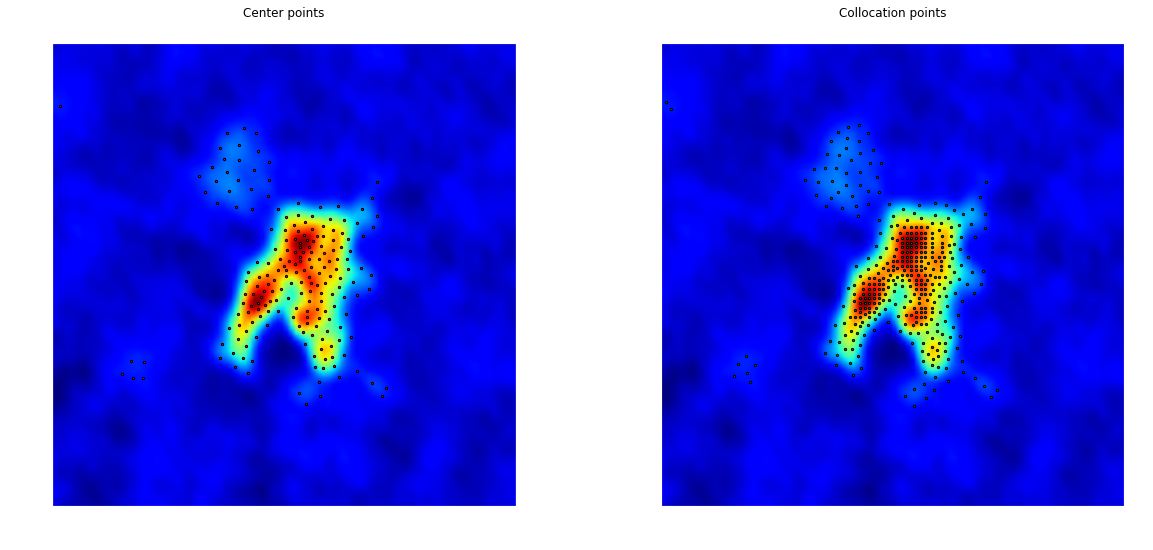

In [42]:
points_plot(data, center_points=center_points, collocation_points=collocation_points)

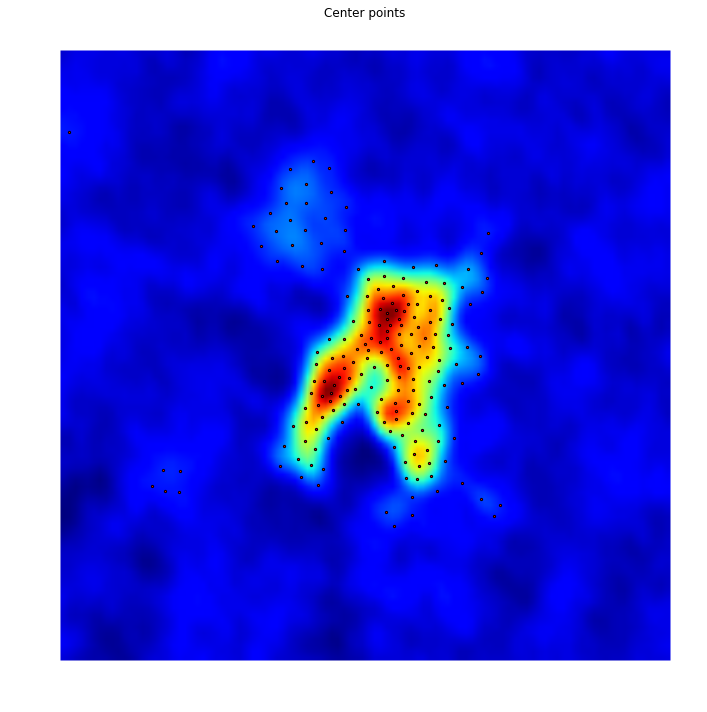

In [43]:
points_plot(data, center_points=center_points)

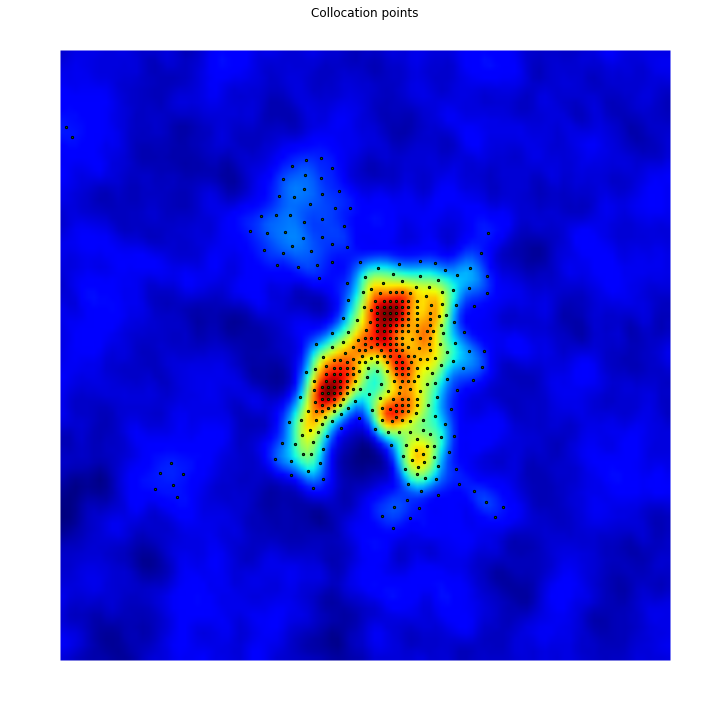

In [44]:
points_plot(data, collocation_points=collocation_points)

In [38]:
xc = center_points[:,0]
yc = center_points[:,1]
xe = collocation_points[:,0]
ye = collocation_points[:,1]

## Initial Conditions

In [20]:
center_points.shape

(200, 2)

In [22]:
@numba.jit('float64 (float64[:], float64[:])', nopython=True)
def dist(p1, p2):
    return sqrt((p1[0]-p2[0])**2.+(p1[1]-p2[1])**2.)

def estimate_initial_guess(center_points, dfunc, R=0.05, method='min_dist'):
    m,n = center_points.shape
    c_arr = np.empty(m, dtype=float)
    sig_arr = np.empty(m, dtype=float)
    
    if method=='mean_dist':
        f = 1./sqrt(log(2.))
        mean_dist = np.zeros(m, dtype=float)
        num_neigh = np.zeros(m, dtype=float)   
        for i in range(m):
            for j in range(m):
                #dont take into account the same point
                if i==j: continue
                d = dist(center_points[i],center_points[j])
                #dont take into account points outside R radius
                if d>R: continue
                num_neigh[i] += 1
                mean_dist[i] += d
            """
            Key Idea: The mean distance to neighbors acurrs when the
            gaussian function has decayed to the half
            """
            if num_neigh[i]==0:
                c_arr[i] = dfunc(*center_points[i])[0]
                sig_arr[i] = 3*R
            else:
                mean_dist[i] /= num_neigh[i]
                #c_arr[i] = dfunc(*center_points[i])[0]/num_neigh[i]**1
                c_arr[i] = dfunc(*center_points[i])[0]*mean_dist[i]**2
                sig_arr[i] = f*mean_dist[i]
                
    elif method=='min_dist':
        min_dist = np.zeros(m, dtype=float)
        num_neigh = np.zeros(m, dtype=float)
        for i in range(m):
            for j in range(m):
                #dont take into account the same point
                if i==j: continue
                d = dist(center_points[i],center_points[j])
                if d<min_dist[i]: min_dist[i] = d
        num_neigh = np.zeros(m, dtype=float)
        for i in range(m):
            for j in range(m):
                #dont take into account the same point
                d = dist(center_points[i],center_points[j])
                if d > 3*min_dist[i]: continue
                num_neigh[i] += 1
            """
            some explanation here
            """
            c_arr[i] = dfunc(*center_points[i])[0]/num_neigh[i]**2
            sig_arr[i] = min_dist[i] 
    return c_arr, sig_arr

In [30]:
c0, sig0 = estimate_initial_guess(center_points, f, R=0.009, method='mean_dist')
c0 = np.sqrt(c0)

## Visualizing the initial solution

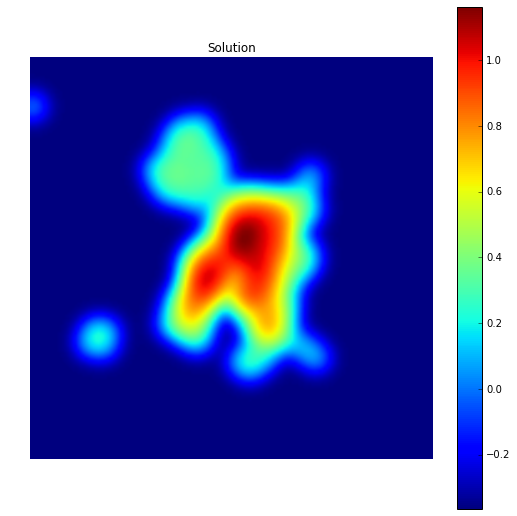

In [31]:
plot_sol(c0, sig0, xc, yc, cut_value=estimate_rms(data))

## Solving it!

In [156]:
elf1 = ELFunc(f, xe, ye, xc, yc, xb, yb, c0, sig0, d1psi1=d1psi, d1psi2=d1psi, d2psi2=d2psi)
elf2 = ELFunc(f, xe, ye, xc, yc, xb, yb, c0, sig0, d1psi1=d1psi, d1psi2=d1psi, d2psi2=d2psi, cut_value=0.)
elf3 = ELFunc(f, xe, ye, xc, yc, xb, yb, c0, sig0, d1psi1=d1psi, d1psi2=d1psi, d2psi2=d2psi, cut_value=estimate_rms(data))
elf = elf3

In [157]:
def el_solver(elf, method='iterative', n_iter=3, verbose=True):
    if method=='exact':
        sol = sp.optimize.root(elf.F, np.concatenate([elf.c, elf.sig]), method='krylov', options={'maxiter':1000})
        opt_c = sol.x[0:Nc]
        opt_sig = sol.x[Nc:]
        print('\nmessage: {0}'.format(sol['message']))
        print('\nsuccess: {0}'.format(sol['success']))
        #print('\nopt_c_squared:\n {0}'.format(opt_c**2))
        #print('\nopt_sig:\n {0}'.format(opt_sig))
        print('-------------------------------------------------------------------')
    
    elif method=='iterative':
        for i in range(n_iter):
            #solve for c
            sol = sp.optimize.root(elf.F1, elf.c, method='lm', options={'maxiter':1000})
            opt_c = sol.x
            delta_c = np.linalg.norm(opt_c-elf.c)
            elf.set_c(opt_c)
            #title = 'Best solution at iter={0} and improved c'.format(i)
            plot_sol(elf.c, elf.sig, elf.xc, elf.yc, cut_value=estimate_rms(data))
            print('Variation on c={0}'.format(delta_c))
            print('\nnfev: {0}'.format(sol['nfev']))
            print('\nmessage: {0}'.format(sol['message']))
            print('\nsuccess: {0}'.format(sol['success']))
            print('------------------------------------------------------------')

            #solve for sig
            sol = sp.optimize.root(elf.F2, elf.sig, method='lm', options={'maxiter':10000})
            opt_sig = sol.x
            delta_sig = np.linalg.norm(opt_sig-elf.sig)
            elf.set_sig(opt_sig)
            #title = 'Best solution at iter={0} and improved sig'.format(i)
            plot_sol(elf.c, elf.sig, elf.xc, elf.yc, cut_value=estimate_rms(data))
            print('Variation on sig={0}'.format(delta_sig))
            print('\nnfev: {0}'.format(sol['nfev']))
            print('\nmessage: {0}'.format(sol['message']))
            print('\nsuccess: {0}'.format(sol['success']))
            print('-------------------------------------------------------------') 

In [159]:
#el_solver(elf, method='iterative', n_iter=5)
el_solver(elf, method='exact')


message: The maximum number of iterations allowed has been reached.

success: False
-------------------------------------------------------------------
